## Importy

In [1]:
from skimage import io
from skimage.filters import frangi
from matplotlib import pylab as plt
import numpy as np
import cv2 as cv

## Analiza statystyczna

In [2]:
def createConfusionMatrix(processed_image, result_image):
    TP, TN, FP, FN = 0, 0, 0, 0

    confusion_matrix_image = np.zeros((processed_image.shape[0], processed_image.shape[1], 3), np.uint8)
    
    for i in range(len(processed_image)):
        for j in range(len(processed_image[0])):
            
            if processed_image[i][j] == 0 and result_image[i][j] == 0:
                TN += 1
            elif processed_image[i][j] == 0 and result_image[i][j] == 255:
                FN += 1
                confusion_matrix_image[i][j] = (255, 0, 0)
            elif processed_image[i][j] == 255 and result_image[i][j] == 0:
                FP += 1
                confusion_matrix_image[i][j] = (0, 0, 255)
            else:
                TP += 1
                confusion_matrix_image[i][j] = (255, 255, 255)
    
    return TP, TN, FP, FN, confusion_matrix_image

def calculateAccuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + TN + FP + FN)

def calculateSensitivity(TP, TN, FP, FN):
    return TP / (TP + FN)

def calculateSpecificity(TP, TN, FP, FN):
    return TN / (TN + FP)

def calculatePrecision(TP, TN, FP, FN):
    return TP / (TP + FP)

def calculateGMean(TP, TN, FP, FN):
    sensitivity = calculateSensitivity(TP, TN, FP, FN)
    specificity = calculateSpecificity(TP, TN, FP, FN)
    
    return np.sqrt(sensitivity * specificity)

def calculateFMeasure(TP, TN, FP, FN):
    precision = calculatePrecision(TP, TN, FP, FN)
    sensitivity = calculateSensitivity(TP, TN, FP, FN)
    
    return (2 * precision * sensitivity) / (precision + sensitivity)

def displayStatisticalAnalysis(processed_image, result_image):
    TP, TN, FP, FN, confusion_matrix_image = createConfusionMatrix(processed_image, result_image)
    
    print("Accuracy:    ", calculateAccuracy(TP, TN, FP, FN))
    print("Sensitivity: ", calculateSensitivity(TP, TN, FP, FN))
    print("Specificity: ", calculateSpecificity(TP, TN, FP, FN))
    print("Precision:   ", calculatePrecision(TP, TN, FP, FN))
    print("G-Mean:      ", calculateGMean(TP, TN, FP, FN))
    print("F-Measure:   ", calculateFMeasure(TP, TN, FP, FN))
    
    return confusion_matrix_image

## Przetwarzanie obrazu

In [5]:
class ImageBuilder:
    def __init__(self):
        self.image = None
        
    def loadImage(self, filename):
        self.image = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)
        return self
    
    def extractGreenChannel(self):
        b, g, r = cv.split(self.image)
        self.image = g
        return self
    
    def applyClahe(self):
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        self.image = clahe.apply(self.image)
        return self

    def increaseContrast(self):
        self.image = cv.addWeighted(self.image, 2, self.image, 0, 0)
        return self

    def toGray(self):
        self.image = cv.cvtColor(self.image, cv.COLOR_RGB2GRAY)
        return self

    def medianBlur(self):
        self.image = cv.medianBlur(self.image, 5)
        return self
    
    def adaptiveThreshold(self):
        self.image = cv.adaptiveThreshold(\
                    self.image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 13, 2)
        return self

    def denoise(self):
        self.image = cv.fastNlMeansDenoising(self.image, None, 3, 7, 21)
        return self
    
    def denoiseByContours(self):
        mask = np.ones([self.image.shape[0], self.image.shape[1]], dtype="uint8") * 255
        contours, _ = cv.findContours(self.image.copy(), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv.contourArea(cnt) <= 200:
                cv.drawContours(mask, [cnt], -1, 0, -1)
        self.image = cv.bitwise_and(self.image, self.image, mask=mask)
        return self

    def applyOpening(self, k):
        self.image = cv.morphologyEx(self.image, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (k, k)), iterations=1)
        return self

    def applyClosing(self, k):
        self.image = cv.morphologyEx(self.image, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (k, k)), iterations=1)
        return self

    def build(self):
        return self.image
        

Accuracy:     0.9361006840173507
Sensitivity:  0.6721387456081334
Specificity:  0.9558899518581413
Precision:    0.5332289553902905
G-Mean:       0.8015551591633293
F-Measure:    0.5946796830562059


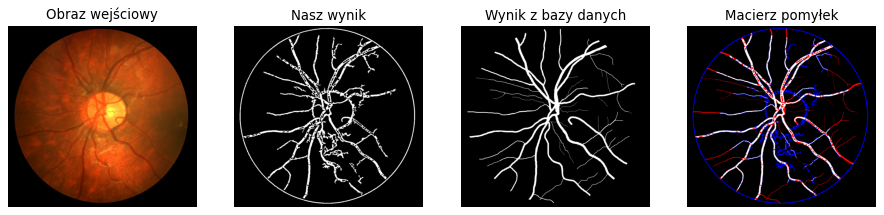

In [6]:
def main():
    directory_prefix = 'CHASEDB1/'
    images = ['Image_01L.jpg', 'Image_01R.jpg']
    results = ['Image_01L_1stHO.png', 'Image_01L_2ndHO.png', 'Image_01R_1stHO.png', 'Image_01R_2ndHO.png',]
    
    input_image = ImageBuilder()\
                    .loadImage(directory_prefix + images[0])\
                    .build()
    
    processed_image = ImageBuilder()\
                        .loadImage(directory_prefix + images[0])\
                        .denoise()\
                        .increaseContrast()\
                        .extractGreenChannel()\
                        .applyClahe()\
                        .applyOpening(5)\
                        .applyClosing(5)\
                        .adaptiveThreshold()\
                        .denoiseByContours()\
                        .applyClosing(5)\
                        .build()
        
    result_image = ImageBuilder()\
                        .loadImage(directory_prefix + results[0])\
                        .toGray()\
                        .build()
            
    confusion_matrix_image = displayStatisticalAnalysis(processed_image, result_image)
    displayImages(input_image, processed_image, result_image, confusion_matrix_image)
    

def displayImages(inputImage, processedImage, result, confusion_matrix_image):
    fig = plt.figure(figsize=(14, 4), dpi=80)   
    
    ax = fig.add_subplot(141)
    ax.set_title('Obraz wejściowy')
    ax.imshow(inputImage, cmap = 'gray')
    ax.axis('off')
    
    ax = fig.add_subplot(142)
    ax.set_title('Nasz wynik')
    ax.imshow(processedImage, cmap = 'gray')
    ax.axis('off')
    
    ax = fig.add_subplot(143)
    ax.set_title('Wynik z bazy danych')
    ax.imshow(result, cmap = 'gray')
    ax.axis('off')
    
    ax = fig.add_subplot(144)
    ax.set_title('Macierz pomyłek')
    ax.imshow(confusion_matrix_image, cmap = 'gray')
    ax.axis('off')

if __name__ == '__main__':
    main()